In [1]:
#############
# SREX masks
#############


import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pylab as plt 
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from six import string_types


sys.path.append('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing-srex/')

try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")
    

from shapely.geometry import Polygon, MultiPolygon


# Variable
varin='TX90p'
read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc')['Ann']

# Set working dir

#Set annual time axis for input data 
timeaxis=np.arange(1901,2011)

# Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2010
input_data=da.DimArray(read_in_data[:20100101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )

0p5 reference period for  Nasa 2010 :  [1960, 1979]
No of non-NAN grid cells in Mask over Ref period:  1415
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  1216


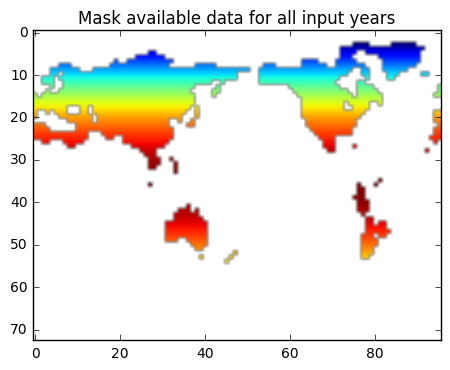

In [2]:
###########
# Settings
###########

# Set GMT dataset
gmtds='Nasa'

# Set Final year in Extreme Event database with sufficient coverage
# 2013 for GHCND, 2010 for HadEx2
ref_year=2010

dgmtp=np.load('/Users/peterpfleiderer/Box Sync/0p5_observational_record/scripts/GMT_time_series/GMT_0p5_diff_intervals.dat')

# print dgmtp#,ref_year,gmtds
ref_period=dgmtp[ref_year][gmtds][::-1]

print '0p5 reference period for ',gmtds,ref_year,': ',ref_period
target_periods=[[ref_year-19,ref_year]]
period_names=['Recent','ref']


# Mask for data availability
varpdf=pdf.PDF_Processing(varin,'/Users/peterpfleiderer/Documents/Projects/0p5_observed/')
varpdf.mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods)

# Plot data mask
plt.figure()
plt.imshow(varpdf._masks['global'][::-1,:])
plt.title('Mask available data for all input years')

plt.show()

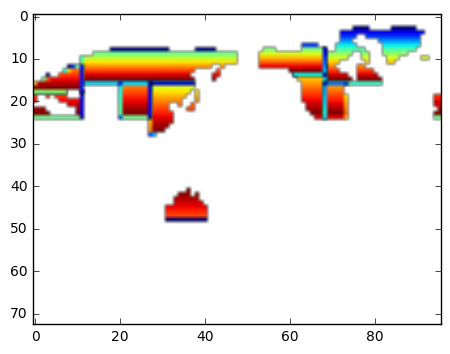

In [3]:
#########
# regional masking
#########

pkl_file = open('srex_dict.pkl', 'rb')
srex_polygons = pickle.load(pkl_file)
pkl_file.close()  

varpdf.derive_regional_masking(input_data,shift_lon=-180.0,regions_polygons=srex_polygons)

for region in varpdf._masks.keys():
    if region!='global':
        plt.imshow(varpdf._masks[region][::-1,:])
plt.show()

Recent [1991, 2010]


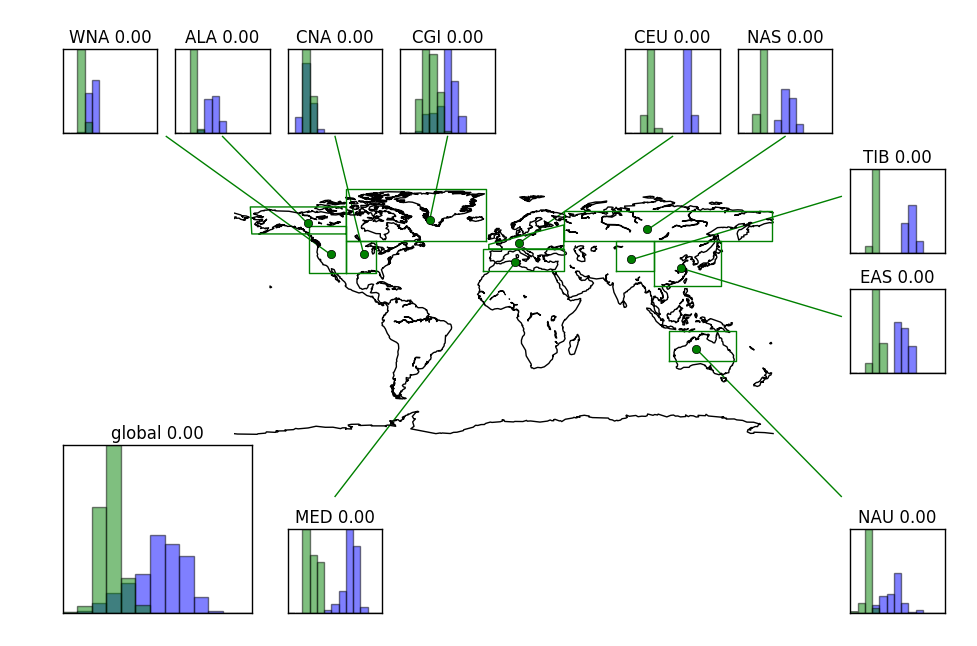

In [5]:
###########
# Derive time slices and distributions
###########
varpdf.derive_time_slices(input_data,ref_period,target_periods,period_names)
varpdf.derive_distributions()

# compute ks test
varpdf.ks_test()

# plot function applied to all regions
def small_distribution(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])

    for key in varpdf._periods:
        histo=subax.hist(varpdf._distributions[region][key],bins=range(7,30,1),alpha=0.5)#,bins=20)
    subax.set_title(region+' %.2f'%varpdf._ks[region])
    subax.set_xlim([7,20])
    subax.set_ylim([0,histo[0].max()])

varpdf.show_result(small_distribution,srex_polygons,output_name=None)

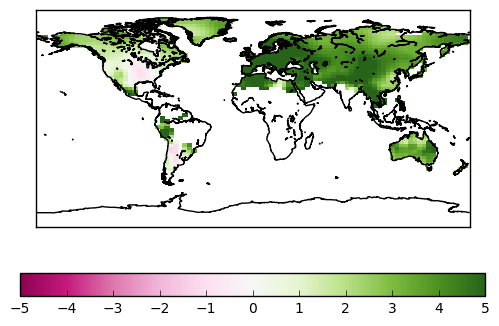

In [10]:
###########
# Show map with information on grid-cell level
###########

varpdf.show_maps(None)

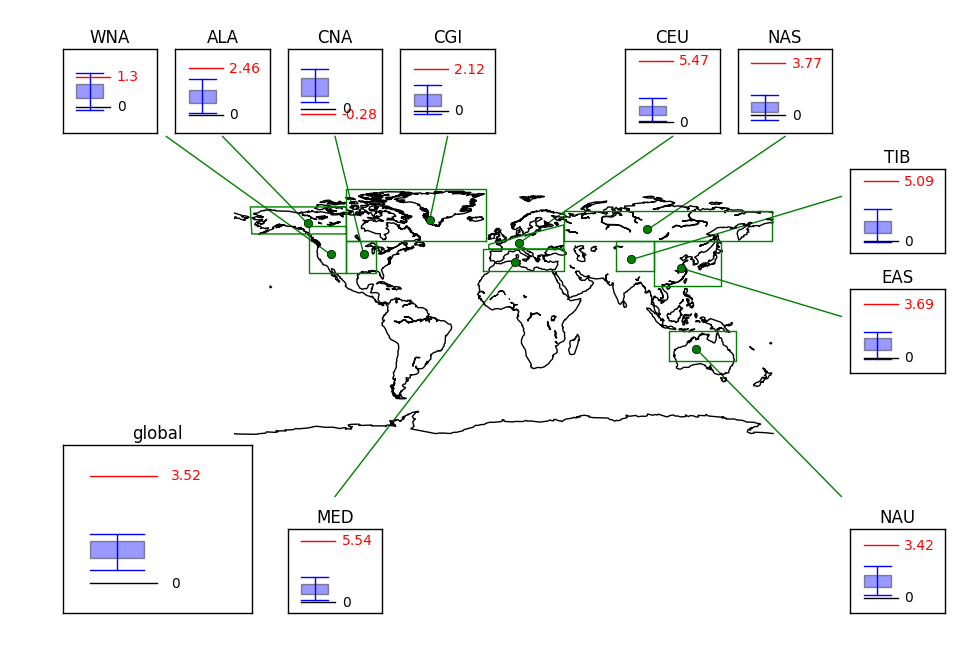

In [9]:
###########
# Bootstrapping
###########

# generate shuffled samples
varpdf.bootstrapping(input_data,100)

# compute regional mean for both periods and all samples
# compute differences between means and the quantiles for sample-differences
varpdf.simple_difference()

# plot function applied to all regions
def small_boxplot(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])

    box=[varpdf._difference[region]['quantiles'][i][1] for i in [3,5]]
    subax.add_collection(PatchCollection([patches.Polygon([(4,box[0]),(6,box[0]),(6,box[1]),(4,box[1])])], alpha=0.4))
    polygon=Polygon([(4,box[0]),(6,box[0]),(6,box[1]),(4,box[1])]).exterior.xy
    whisker=[varpdf._difference[region]['quantiles'][i][1] for i in [1,7]]
    subax.plot([4,6],[whisker[0],whisker[0]],'b')
    subax.plot([4,6],[whisker[1],whisker[1]],'b')
    subax.plot([5,5],[whisker[0],whisker[1]],'b')

    subax.plot([4,6.5],[varpdf._difference[region]['Recent-ref'],varpdf._difference[region]['Recent-ref']],color='r')
    subax.text(7,varpdf._difference[region]['Recent-ref'],round(varpdf._difference[region]['Recent-ref'],2),color='r',va ='center',ha='left').set_fontsize(10)

    subax.plot([4,6.5],[0,0],'k')
    subax.text(7,0,0,va ='center',ha='left').set_fontsize(10)

    subax.title.set_text(region)
    subax.set_xlim([3,10])
    subax.set_ylim([min(varpdf._difference[region]['Recent-ref'],0,whisker[0])-1,max(varpdf._difference[region]['Recent-ref'],0,whisker[1])+1])

varpdf.show_result(small_boxplot,srex_polygons,output_name=None)

In [11]:
############
# Kernel Density Estimation
############

# define plot funcions used later on
# For pdf
def small_kde(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])

    #legend dict
    ldict={
        'ref':str(ref_period[0])+' to '+str(ref_period[1]),
        'Recent':str(target_periods[0][0])+' to '+str(target_periods[0][1])
    }

    for key in varpdf._periods:
        pdf_distro=varpdf._distributions[region][key+'_pdf']
        subax.plot(pdf_distro[:,0],pdf_distro[:,1],label=ldict[key])
    subax.set_title(region+' %.2f'%varpdf._ks[region])
    subax.set_xlim([7,20])
    subax.set_ylim([0,pdf_distro[:,1].max()])

# for cdf
def small_cumul(subax,region):
    subax.axes.get_xaxis().set_ticks([])
    subax.axes.get_yaxis().set_ticks([])
    subax.set_xticklabels([])
    subax.set_yticklabels([])

    #legend dict
    ldict={
        'ref':str(ref_period[0])+' to '+str(ref_period[1]),
        'Recent':str(target_periods[0][0])+' to '+str(target_periods[0][1])
    }

    for key in varpdf._periods:
        cdf_distro=varpdf._distributions[region][key+'_cdf']
        subax.plot(cdf_distro[:,0],cdf_distro[:,1],label=ldict[key])
    subax.set_title(region+' %.2f'%varpdf._ks[region])
    subax.set_xlim([7,20])
    subax.set_ylim([0,1])

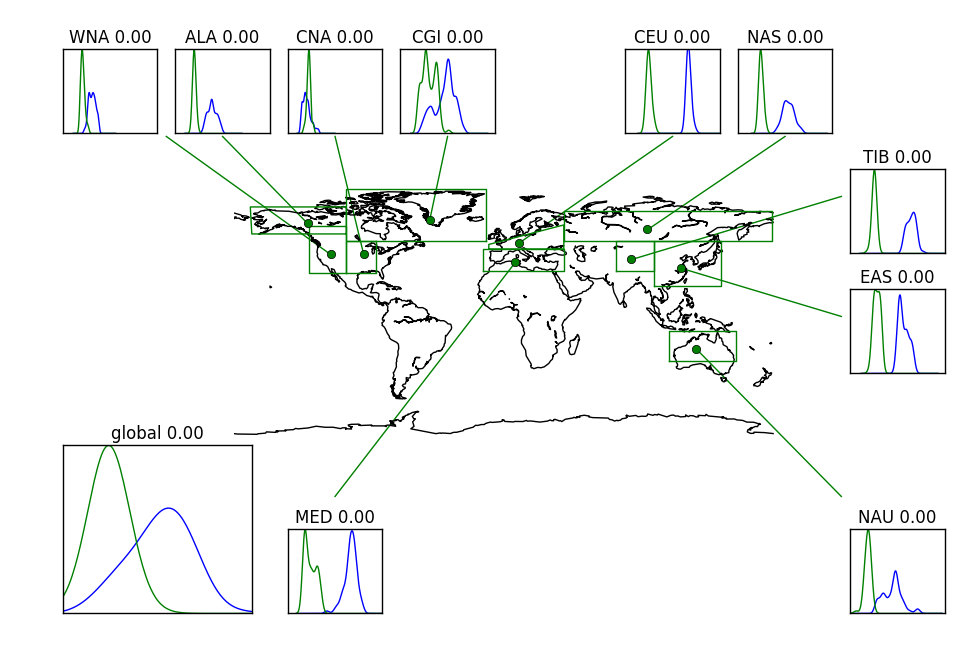

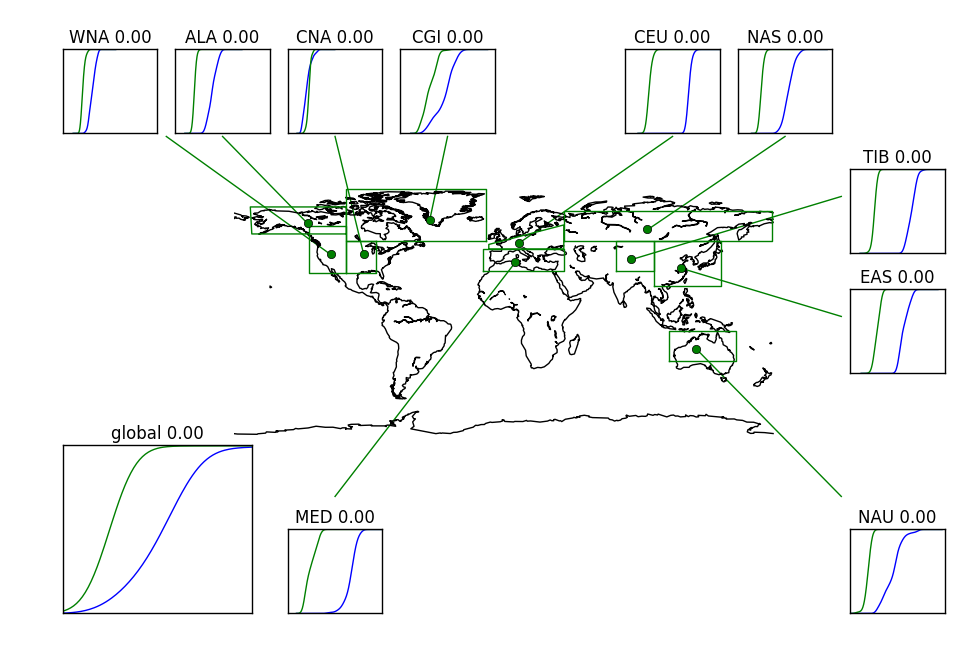

In [12]:
##############
# kernel_in_R
##############

for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['ref'].min()*0.9,varpdf._distributions[region]['Recent'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_in_R(cutinterval,bw,region=region)

varpdf.show_result(small_kde,srex_polygons,output_name=None)
varpdf.show_result(small_cumul,srex_polygons,output_name=None)

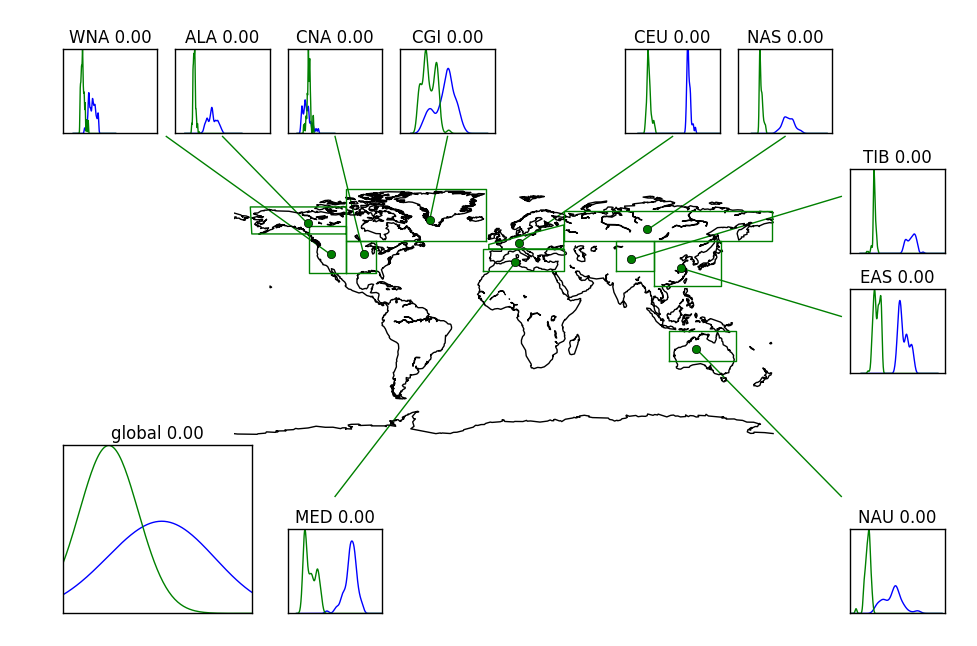

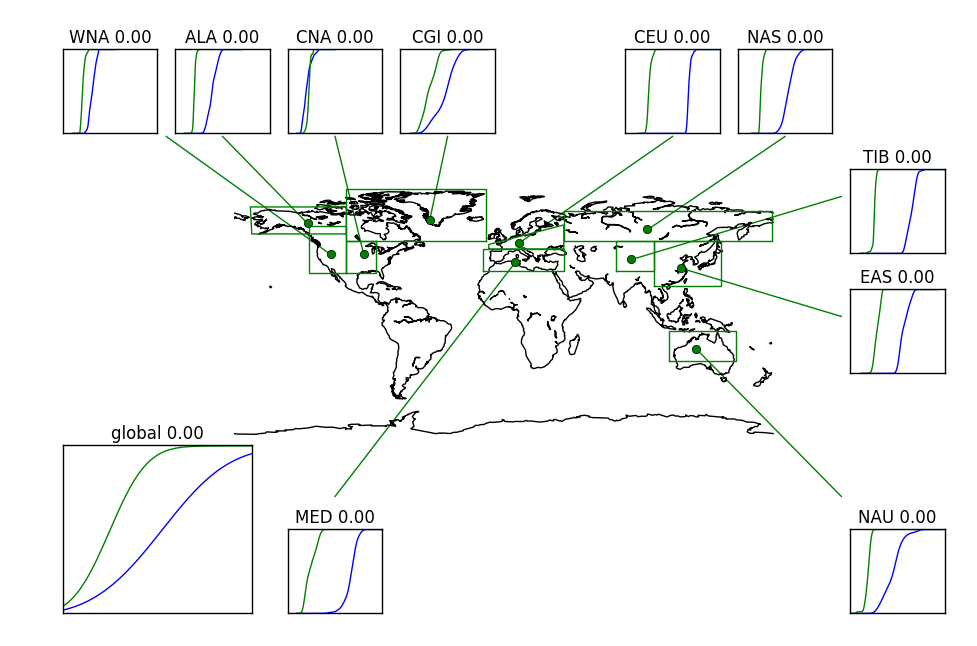

In [13]:
##############
# kernel_in_PY - same bandwith
##############

for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['ref'].min()*0.9,varpdf._distributions[region]['Recent'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_in_PY(cutinterval,bw,region=region)

varpdf.show_result(small_kde,srex_polygons,output_name=None)
varpdf.show_result(small_cumul,srex_polygons,output_name=None)

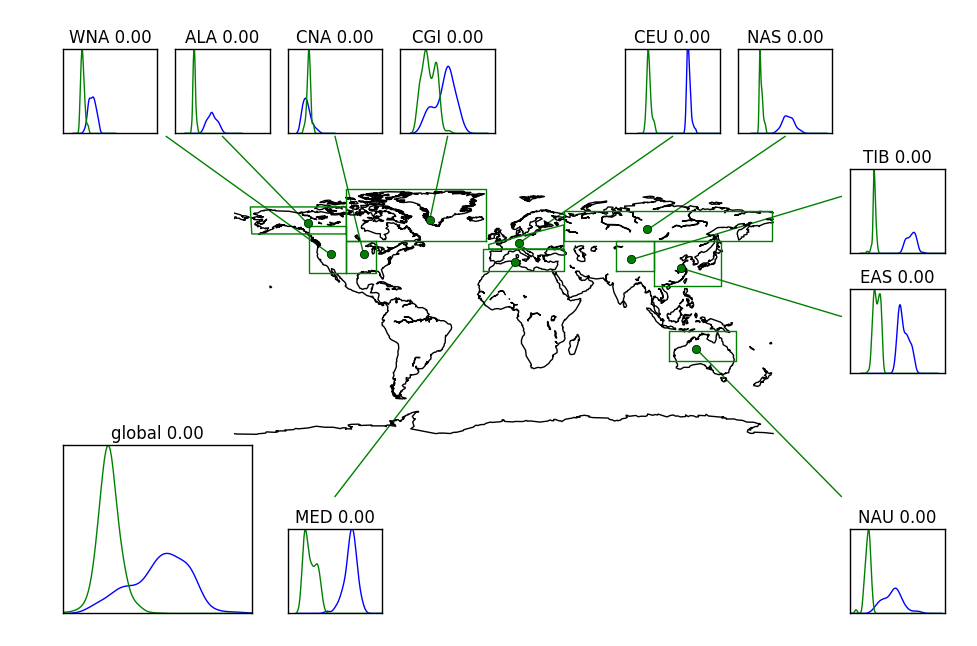

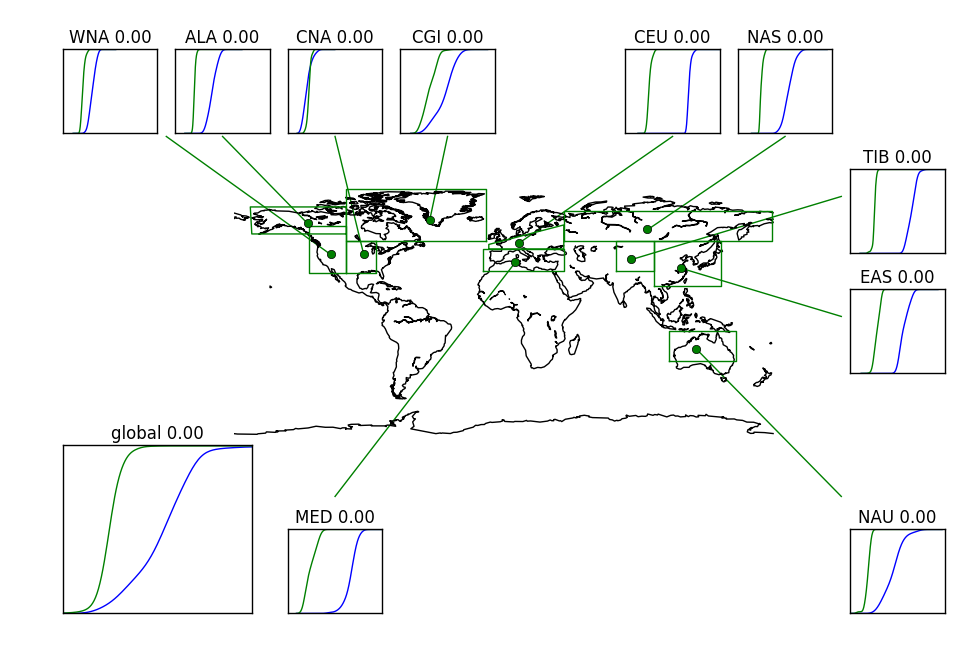

In [14]:
##############
# kernel_in_PY - bandwith extimated with 'scott'
##############

for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['ref'].min()*0.9,varpdf._distributions[region]['Recent'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_in_PY(cutinterval,'scott',region=region)

varpdf.show_result(small_kde,srex_polygons,output_name=None)
varpdf.show_result(small_cumul,srex_polygons,output_name=None)

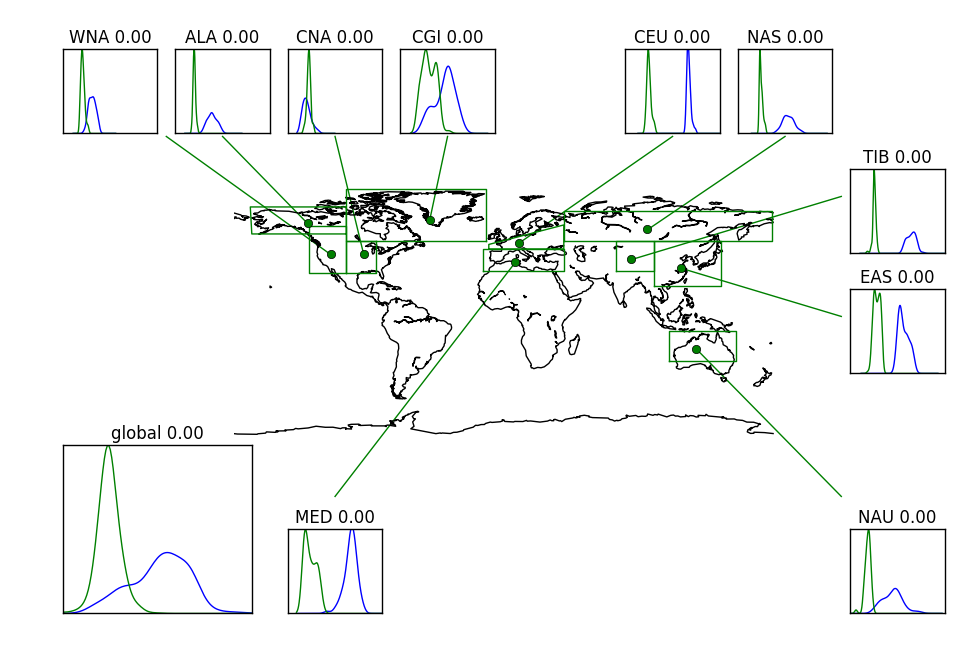

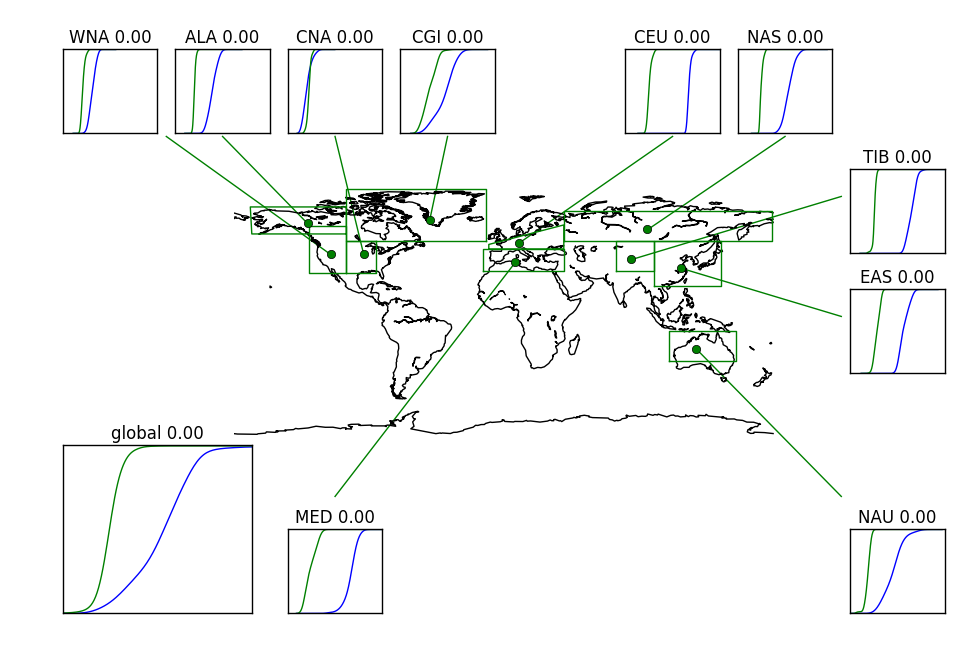

In [15]:
##############
# kernel_in_PY - bandwith extimated with 'silverman'
##############

for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['ref'].min()*0.9,varpdf._distributions[region]['Recent'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_in_PY(cutinterval,'silverman',region=region)

varpdf.show_result(small_kde,srex_polygons,output_name=None)
varpdf.show_result(small_cumul,srex_polygons,output_name=None)